In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import fitz
from fitz import Rect
import sys, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

from pdf_scraper.doc_utils   import (open_exam, get_doc_line_df, identify_section_headers, 
                                     identify_text_headers, get_path_from_doc, identify_footers, 
                                     identify_instructions, identify_subtitles, identify_subsubtitles,
                                     get_images, preproc_images, assign_in_image_captions, 
                                     identify_vertical_captions, enrich_doc_df_with_images, identify_all_page_clusters)
from pdf_scraper.general_utils import shared_centre

from pdf_scraper.draw_utils  import draw_rectangles_on_page, draw_rectangles_for_all_pages
from pdf_scraper.line_utils  import is_buffered_line, clean_line_df, get_df_bbox
from pdf_scraper.clustering.cluster_utils import find_y0_dL

from pdf_scraper.image_utils import show_image, show_all_imgs

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 200)


In [13]:
year=2013
doc    = open_exam(year, "english", "al",1)
df     = get_doc_line_df(doc)

images = get_images(doc)
images = preproc_images(images)
assign_in_image_captions(df,images)

doc_width     = doc[0].rect.width
middle        = doc_width/2
standard_font = df.mode_font.mode()[0]
median_font   = df.font_size.median()

df = clean_line_df(df)
df = enrich_doc_df_with_images(df, images)

identify_all_page_clusters(df, 2.0/3.0, 1.15, True)
identify_footers(df)
identify_instructions(df)
identify_section_headers(df)
identify_text_headers(df, doc_width)
identify_subtitles(df, doc_width)
identify_subsubtitles(df,doc_width)

for img in images:
    identify_vertical_captions(df, img)

result = df[(df.category=="caption2") ].copy()

result[["text","font_size", "page","mode_font","y0","dL","h","page","w","counts","category"]].head(14)

text  font_size  page  \
205                           William Trevor      12.00     4   
342                                  Image 1      12.00     6   
344  John Collier’s iconic photograph of the      12.00     6   
421                                  Image 2      12.00     7   
423   The concourse of Grand Central Station      12.00     7   

                    mode_font     y0      dL     h  page      w  counts  \
205  TimesNewRomanPS-BoldItal 497.09 -435.30 13.28     4  78.67       2   
342    TimesNewRomanPS-BoldMT 541.31   13.80 13.28     6  43.93       2   
344  TimesNewRomanPS-BoldItal 555.11   13.80 13.28     6 198.72       2   
421    TimesNewRomanPS-BoldMT 418.25   13.74 13.28     7  43.93       2   
423  TimesNewRomanPS-BoldItal 431.99 -403.26 13.28     7 199.70       2   

     category  
205  caption2  
342  caption2  
344  caption2  
421  caption2  
423  caption2

In [15]:
df.loc[344:348].text

344             John Collier’s iconic photograph of the
345           They show the concourse pinioned by great
346                  concourse of Grand Central Station
347    shafts of sunlight.  Who wouldn’t want to turn a
348     In the early Richard Yates’ story A Glutton for
Name: text, dtype: object

In [16]:
p6_ims =[img for img in images if img["page"]==6]
#show_image(p4_ims[0])
mary_rob_img = p6_ims[0]
caption_lines = df.loc[[344,346],["x0","y0","x1","y1", "text", "mode_font", "font_size"]]
caption_lines = enrich_doc_df_with_images(caption_lines,[mary_rob_img])
caption_lines.head(5)

x0     y0     x1     y1                                     text  \
0 332.34 327.60 543.48 539.88                                  <image>   
1 340.44 555.11 536.16 568.39  John Collier’s iconic photograph of the   
2 349.68 568.91 527.02 582.19       concourse of Grand Central Station   

                  mode_font  font_size  page category  
0                       NaN        NaN  6.00    image  
1  TimesNewRomanPS-BoldItal      12.00   NaN      NaN  
2  TimesNewRomanPS-BoldItal      12.00   NaN      NaN

In [ ]:
i_x0, i_y0, i_x1, i_y1 = mary_rob_img["bbox"]
img_centre = (i_x0 + i_x1)/2
within_image_frame = (df.x0 >= i_x0 -2 ) & (df.x1 <= i_x1 +2 )
centred = df.apply( lambda row: shared_centre( (row["x0"],row["y0"],row["x1"],row["y1"] ),mary_rob_img["bbox"]) , axis=1 )
uncategorised    = (df.section==0) & (df.caption1 ==0) & (df.instruction==0) & (df.title ==0 ) & (df.footer==0) & (df.subtitle ==0 )
above_top        = abs(i_y0 - df.y1) <= df.h*2.0
# We will not use above_top as a condition. There are no captions above images in all pdfs I have seen and it causes non-caption 
# text to be captured.
below_bottom     = abs(df.y0 -i_y1)  <= df.h*2.0
page             = df.page == mary_rob_img["page"]
mask = page & within_image_frame & centred &  uncategorised &  below_bottom

df.loc[mask, "caption2"] = 1

x0     y0     x1     y1  \
204 327.48 388.80 548.67 400.95   
206 375.00 401.40 498.39 413.55   

                                              text                 mode_font  \
204  Mary Robinson with Nadhifa Ibrahim Mohamed,    TimesNewRomanPS-ItalicMT   
206                    a health-worker in Somalia   TimesNewRomanPS-ItalicMT   

     font_size  
204      10.98  
206      10.98

In [108]:
# Wisely determine dL
dL =find_y0_dL(df, "caption2")
print(dL)

line_scale = 1.15


page = np.unique(df[df.caption2==1].page)[0]
# DBSCAN to cluster doc page
clust_df = df[df.page==page].copy()
eps = dL*1.15; min_neighbs = 2
scan = DBSCAN(eps=eps, min_samples=min_neighbs)
scan.fit(clust_df[["y0"]])
clust_df["cluster"]=scan.labels_

14.6400146484375


- If the caption belongs to a contiguous block that is 100% not captions. Then make it not a caption as well.

In [111]:
for i, row in clust_df[clust_df.caption2==1].iterrows():
    i_clust = row.cluster
    if i_clust == -1: # We can have just a one line caption out somewhere on its own.
        continue
    clust_caption = np.unique(clust_df.loc[ (clust_df.index !=i) & (clust_df.cluster==i_clust) , "caption2" ])
    if len(clust_caption) == 1 and clust_caption[0]==0:
        clust_df.loc[i, "caption2"] = 0
        
        
clust_df.loc[clust_df.caption2==1, ["text","y0","cluster","caption2"]].head(45)

Empty DataFrame
Columns: [text, y0, cluster, caption2]
Index: []

In [ ]:
# Draw clusters on page
rectangies = []
for i in np.unique(scan.labels_)[1:]:
    temp_df = clust_df[clust_df.cluster==i]
    rectangies.append( Rect(get_df_bbox(temp_df)) )
rectangies.append( Rect( (0, 0, 10, 10)))
doc_path = get_path_from_doc(doc)
draw_rectangles_on_page(doc_path, "out.pdf", 1,rectangies)

In [33]:
fart = [img for img in images if img["page"] >=2 and img["page"] <=6 ]
#for image in images: 
#    if image["page"] >2 and image["page"] <6 and year !=2001:
#        continue
#    identify_vertical_captions(df,image)
len(fart)

3

In [27]:
images[0]["page"]

1

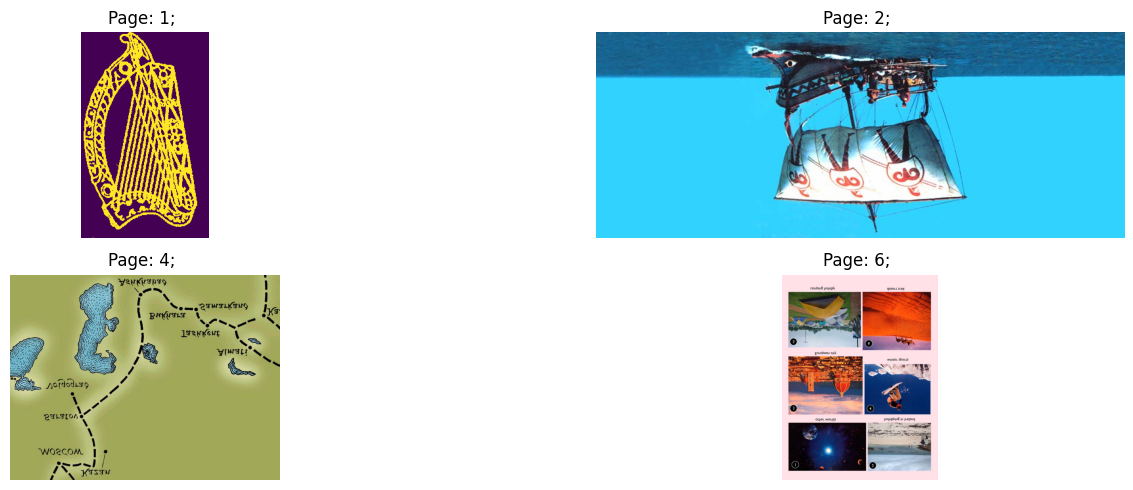

In [26]:
show_all_imgs(2,2,images)

In [ ]:
i_x0, i_y0, i_x1, i_y1 = mary_rob_img["bbox"]
img_centre = (i_x0 + i_x1)/2
within_image_frame = (df.x0 >= i_x0) & (df.x1 <= i_x1)
centred = df.apply( lambda row: shared_centre( (row["x0"],row["y0"],row["x1"],row["y1"] ),mary_rob_img["bbox"]) , axis=1 )
uncategorised    = (df.section==0) & (df.caption1 ==0) & (df.instruction==0) & (df.title ==0 ) & (df.footer==0) & (df.subtitle ==0 )
above_top        = (i_y0 - df.y1) <= df.h*2.0
below_bottom     = (df.y0 -i_y1)  <= df.h*2.0
page             = df.page == mary_rob_img["page"]
mask = page & within_image_frame & centred &  uncategorised & (above_top | below_bottom)

df.loc[mask, "caption2"] = 1

In [ ]:
doc_df["adjacent_image"]

In [4]:
images

[{'number': 12,
  'type': 1,
  'bbox': (78.30000305175781,
   46.739990234375,
   128.5800018310547,
   118.739990234375),
  'width': 167,
  'height': 237,
  'ext': 'png',
  'colorspace': 1,
  'xres': 96,
  'yres': 96,
  'bpc': 8,
  'transform': (50.279998779296875,
   0.0,
   -0.0,
   72.0,
   78.30000305175781,
   46.739990234375),
  'size': 3206,
  'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa7\x00\x00\x00\xed\x08\x02\x00\x00\x00U\xb7\xf2\xb1\x00\x00\x00\tpHYs\x00\x00\x0e\xc4\x00\x00\x0e\xc4\x01\x95+\x0e\x1b\x00\x00\x0c8IDATx\x9c\xed\x9a\xdbr$)\x0cD\xf9\xff\x9f\xce\x8dX{\xdatq\xd3\x15\x04E>l\xb4)J)\xe9\x80z\xc6;\tW\xefSZ\x9d\x00[\xe9\x7f\xad\xcebom\xd6\xbe\x94iu.\x1bk\xb3\xde\xa5o\xadNgW\xed\xd4\xb8T\xd3\xea\xa4\xb6\xd4N]\xabR\xbf\xe0\x05\xda\xa6e-\xe4\x17\xbc@\xdb\xf4\xabO\xfd<\xf6\xaeE\xed\xd1)\n\xf2\xc3\xc0\xbb\x96\xb6A\x9b\xe8\xc8O\x02\xefZ\xe3\x06=\xe2R?\x00\xbcw\xa5\xd1\x1b$@~\x00\xfbK]\xa5\xd5\xe9\x0b\xf5j\xeaJ\xe4\xfb\xb2\xf7\xae+nG\xac\x90o\x07~BQq\xdbaK}#\x

In [34]:
single_line      = (df.counts == 0)
title_on_page    = df.groupby('page')['title'].transform('sum') >0
subtitle_on_page = df.groupby('page')['subtitle'].transform('sum') >0
pages            = (df.page > 1) & (df.page <9)
uncategorised    = (df.section==0) & (df.caption ==0) & (df.instruction==0) & (df.title ==0 ) & (df.footer==0) & (df.subtitle ==0 )
after_subtitles  = df[uncategorised].groupby('page')['y0'].rank(method='first', ascending=True) <=10
italic_or_bold   = (df.mode_font.str.contains("Bold") | df.mode_font.str.contains("Italic") )

mask = single_line & title_on_page & subtitle_on_page & pages & uncategorised & after_subtitles & italic_or_bold
df.loc[mask, "subsubtitle"] = 1


df.loc[df.subsubtitle==1,["text","font_size", "page","mode_font","y0","dL","h","page","w","counts"] ]

Empty DataFrame
Columns: [text, font_size, page, mode_font, y0, dL, h, page, w, counts]
Index: []

In [13]:
small_df = df[["y0","y1","x0","x1","page","text","h"]].copy()
small_df

y0     y1     x0     x1  page                                    text  \
0    32.39  45.67 486.90 549.24     1                            2009.  M.11    
1    50.86  77.42 146.46 462.45     1          Coimisiún na Scrúduithe Stáit    
2    78.46 105.02 135.48 473.50     1          State Examinations Commission    
3   125.35 140.95 147.90 451.24     1  LEAVING CERTIFICATE EXAMINATION, 2009    
4   163.99 192.75 115.68 486.16     1       English – Higher Level – Paper I    
..     ...    ...    ...    ...   ...                                     ...   
450 808.09 819.18 492.18 541.13     8                            Page 8 of 8    
451 315.66 387.60 143.04 475.29     9                             Blank Page    
452 327.66 399.60 155.04 487.29    10                             Blank Page    
453 339.66 411.60 167.04 499.29    11                             Blank Page    
454 351.66 423.60 179.04 495.09    12                              Blank Page   

        h  
0   13.28  
1   26.57  
2   26.57  
3   15.60  
4   28.76  
..    ...  
450 11.09  
451 71.93  
452 71.93  
453 71.93  
454 71.93  

[455 rows x 7 columns]

In [ ]:
def get_level_line_counts(df):
    temp_df = df.copy()
    temp_df["index_col"] = temp_df.index
    new_df = temp_df.merge(temp_df,on="page",suffixes=("","_other"))
    new_df = new_df[new_df.index_col != new_df.index_col_other ]
    new_df["y_diff"] = abs(new_df["y0"] - new_df["y0_other"])

    new_df = new_df[new_df.y_diff <= new_df.h*0.15 ]
    new_df["counts"] = new_df.groupby("index_col")["index_col"].transform("count")
    counts_per_index = new_df.groupby("index_col")["counts"].first().reset_index()
    #new_df[new_df.counts > 0]
    counts_per_index



index_col  counts
0           31       1
1           32       1
2           33       1
3           34       1
4           35       1
..         ...     ...
309        440       1
310        443       1
311        444       1
312        446       1
313        447       1

[314 rows x 2 columns]

In [ ]:
def get_level_line_counts(df):
    temp_df = df[['y0', 'h', 'page']].copy()
    temp_df["index_col"] = temp_df.index

    new_df = temp_df.merge(temp_df, on="page", suffixes=("", "_other"))
    new_df = new_df[new_df.index_col != new_df.index_col_other]

    new_df["y_diff"] = abs(new_df["y0"] - new_df["y0_other"])
    new_df = new_df[new_df["y_diff"] <= new_df["h"] * 0.15]

    counts_per_index = new_df.groupby("index_col").size().reset_index(name="counts")
    counts_series = df.index.map(counts_per_index).fillna(0).astype(int)

    return counts_series

In [36]:
median_dL = result.dL.median()
scan = DBSCAN(eps =median_dL*1.25, min_samples=2)
scan.fit(result[["y0"]])
scan.labels_
result["label"] = scan.labels_
result[["text","font_size", "page","mode_font","y0","dL","h","page","w","label"]].head(9)


text  font_size  \
251  World exclusive ! Irish Rock Diva speaks to readers from       15.00   
252                                        her Italian villa.       15.00   
253                            Hi, my name is Jerry Philips.        12.00   
254                                                      from       12.00   
255                                                       far       12.00   
256                                                       the       12.00   
257                                                   terrace       12.00   
258                 I interview sport stars, superstars, rock       12.00   
259                                 house of her childhood in       12.00   

     page           mode_font     y0    dL     h  page      w  label  
251     6  TimesNewRoman,Bold 145.09 51.09 16.61     6 370.85      0  
252     6  TimesNewRoman,Bold 162.31 34.23 16.61     6 106.69      0  
253     6       TimesNewRoman 196.19 13.80 13.28     6 145.69      1  
254     6       TimesNewRoman 196.55  0.00 13.28     6  26.32      1  
255     6       TimesNewRoman 196.55  0.00 13.28     6  16.32      1  
256     6       TimesNewRoman 196.55  0.00 13.28     6  17.69      1  
257     6       TimesNewRoman 196.55 13.80 13.28     6  35.67      1  
258     6       TimesNewRoman 209.99 13.80 13.28     6 211.72      1  
259     6       TimesNewRoman 210.35 13.80 13.28     6 129.03      1

In [ ]:
italic_or_bold   = (result.mode_font.str.contains("Bold") | result.mode_font.str.contains("Italic") )
result.loc[italic_or_bold, ["text","font_size", "page","mode_font","y0","dL","h","page","w","counts"]]

text  \
31       It was King Pelias who sent them out.  He had heard an oracle which warned him of a dreadful tale –   
32           death through the machinations of the man whom he should see coming from the town with one foot   
33     bare… The prophecy was soon confirmed.  Jason, fording the Anaurus in a winter spate, lost one of his   
34       sandals, which stuck in the bed of the flooding river, but saved the other from the mud and shortly   
35           appeared before the king.  And no sooner did the king see him than he thought of the oracle and   
36  decided to send him on a perilous adventure overseas.  He hoped that things might so fall out, either at   
37                                    sea or in outlandish parts, that Jason would never see his home again.   
38                                                                                                       1.    
45                                                                                                        2.   

    font_size  page             mode_font     y0    dL     h  page      w  \
31      12.00     2  TimesNewRoman,Italic 333.77 13.80 13.28     2 497.80   
32      12.00     2  TimesNewRoman,Italic 347.57 13.80 13.28     2 497.84   
33      12.00     2  TimesNewRoman,Italic 361.37 13.80 13.28     2 497.86   
34      12.00     2  TimesNewRoman,Italic 375.17 13.80 13.28     2 497.83   
35      12.00     2  TimesNewRoman,Italic 388.97 13.80 13.28     2 497.88   
36      12.00     2  TimesNewRoman,Italic 402.77 13.80 13.28     2 497.85   
37      12.00     2  TimesNewRoman,Italic 416.57 18.24 13.28     2 338.76   
38      12.00     2    TimesNewRoman,Bold 434.64  0.17 13.45     2  12.34   
45      12.00     2    TimesNewRoman,Bold 476.21  0.00 13.28     2   9.00   

    counts  
31       1  
32       1  
33       1  
34       1  
35       1  
36       1  
37       1  
38       3  
45       3

# Find lines with y0 within tol

In [ ]:
from sklearn.neighbors import BallTree

h = 3
counts = np.zeros(len(df), dtype=int)

for page, g in df.groupby("page"):
    y = g[["y0"]].values  # needs 2D array
    tree = BallTree(y)
    # query all neighbors within radius h
    ind = tree.query_radius(y, r=h)
    # count neighbors excluding self
    counts[g.index] = [len(i) - 1 for i in ind]

df["counts"] = counts

In [ ]:
def get_line_overlaps(df):
    counts = np.zeros(len(df), dtype=int)
    
    for page, g in df.groupby("page"):
        y = g["y0"].values
        h_vals = g["h"].values*0.1
        row_counts = []
        for i, (yi, hi) in enumerate(zip(y, h_vals)):
            row_counts.append(np.sum(np.abs(y - yi) <= hi))
        counts[g.index] = row_counts
    
    df["counts"] = counts
    return df

df.loc[df.page==2,["text","font_size", "page","mode_font","y0","dL","h","page","w","counts"]].head(30)


text  \
24                                                                                         SECTION I    
25                                                                         COMPREHENDING (100 marks)    
26                                                                                            TEXT 1    
27                                                                              Decisions for Society   
28  This text is taken from Head to Head, a series of public debates, published in April 2008 in The    
29                            Irish Times; it consists of two extracts in response to the question:     
30                                                                            Should Zoos be Closed?    
31                                                            YES, according to Bernie Wright (Press    
32                                                         NO, according to Veronica Chrisp (Head of    
33                                                    Officer of the Alliance for Animal Rights) who    
34                                                        Marketing at Dublin Zoo) who believes zoos    
35                                                  believes zoos will always be prisons for animals.   
36                                                                  connect us to the natural world.    
37                                                              If anybody could witness the look of    
38                                                       A zoo is simply a collection of animals. It    
39                                                    makes money by attracting paying visitors. The    
40                                                         amazement and wonder on the face of a six-   
41                                               quality of life for the animals varies from totally    
42                                                 year-old child as he, or she, sees an elephant, a    
43                                                 snake or a gorilla for the very first time, it is    
44                                                                    inadequate to barely adequate.    
45                                                     unlikely that zoos would ever again be put on    
46                                                  In 2008, Dublin Zoo sits on roughly 60 acres. It    
47                                                                                    the defensive.    
48                                                boasts such habitats as African plains, fringes of    
49                                              the Arctic, rainforests, the Kaziranga forest trail,    
50                                                      Of course, in our culture, the very word zoo    
51                                                   and shops and restaurants. All of this, and 600    
52                                                         has negative connotations – often evoking    
53                                                          ideas of bored animals kept in Victorian    

    font_size  page               mode_font     y0     dL     h  page      w  \
24      16.02     2  TimesNewRomanPS-BoldMT  28.99  18.36 17.73     2  86.34   
25      16.02     2  TimesNewRomanPS-BoldMT  47.35  48.30 17.73     2 237.83   
26      16.02     2  TimesNewRomanPS-BoldMT  95.65  18.36 17.73     2  59.55   
27      16.02     2  TimesNewRomanPS-BoldMT 114.01  32.08 17.73     2 317.45   
28      12.00     2  TimesNewRomanPS-BoldMT 146.09  12.04 13.28     2 485.64   
29      12.00     2  TimesNewRomanPS-BoldMT 158.12  15.80 15.48     2 342.07   
30      18.00     2  TimesNewRomanPS-BoldMT 173.92  30.52 19.93     2 188.08   
31      12.00     2  TimesNewRomanPS-BoldMT 204.44  15.92 15.48     2 212.09   
32      12.00     2  TimesNewRomanPS-BoldMT 205.58  15.92 15.48     2 230.63   
33      12.00     2  TimesNewRomanPS-Bold

In [87]:
page_4 = df[df.page==4]

bold_font     = page_4.mode_font.str.contains("Bold")
starts_left   = page_4.x0 < doc_width/2
pages         = (page_4.page == 2) | (page_4.page ==4) | (page_4.page ==6) | (page_4.page ==8)
title_on_page = page_4.groupby('page')['title'].transform('sum') >0
uncategorised = (page_4.section==0) & (page_4.caption ==0) & (page_4.instruction==0) & (page_4.title ==0 ) & (page_4.footer==0)
after_headers = page_4[uncategorised].groupby('page')['y0'].rank(method='first', ascending=True) <=6

#mask = bold_font & pages & uncategorised & after_headers & title_on_page
mask = bold_font & pages & uncategorised & after_headers & title_on_page & starts_left


In [88]:
test["round_y0"] = test.y0.map(round)
test["counts"] = test.groupby("round_y0")["x0"].transform('count')
test

text  \
105                                                                                                   TEXT 2    
106                                                                                     FAMILY HOME FOR SALE    
107  Novelist, Penelope Lively, remembers her family home through the wealth of little things it contained.     
108                                       This article was published in The Sunday Times of August 26, 2001.    
109                                                           Any house tells a story; its furnishings are a    
110                                                                   A few years ago, the house in which my    
111                                                                 shining reference to some aspect of past    
112                                                            grandmother had set up home in 1923 had to be    
113                                                        habitation.  They seem to me to be more than just    
114                                                            sold.  It had seen more than seventy years of    
115                                                           the backdrop to one family’s life, and to bear    
116                                                         occupancy by my family, and hardly a hair of its    
117                                                          witness to the events of the past.  And in this    
118                                                                 head had been changed during that time.     
119                                                           sense our old home was peculiarly well stocked    
120                                                         Everything was still as it had always been – the    
121                                                             with archival matter.  In a large house with    
122                                                             gong-stand by the front door, the photograph    
123                                                              cupboards and disused rooms, things are not    
124                                                      albums in the hall chest, the tarnished contents of    
125                                                          discarded, they are simply ‘put away’.  Seventy    
126                                                           the silver cupboard, the horsehair mattress on    
127                                                            years of putting away had created strata from    
128                                                             which I slept in the dressing-room during my    
129                                                             which we retrieved my grandmother’s 100-year-   
130                                                                                         school holidays.    
131                                                           old wedding dress, bound volumes of Punch from    
132                                                        the 1880s onwards, Thermos flasks of the 1950s, a    
133                                                                  This country house, tucked away in West    
134                                                      forest of walking sticks, an army of glass jars for    
135                                                               Somerset, had seen out the century, and it    
136                                                         fruit bottling, Primus stoves, preserving pans.     
137                                                           reflected seven decades of social change.  Its    
138                                                             Granted reincarnation, I would like to be an    
139                                                           furnishings were a secret message, if you knew    
140                                  

In [ ]:
fart = test.groupby("y0").count()
test["count_same_y0"] = df.groupby("y0")["x0"].transform("count")
test

text  \
105                                                                                                   TEXT 2    
106                                                                                     FAMILY HOME FOR SALE    
107  Novelist, Penelope Lively, remembers her family home through the wealth of little things it contained.     
108                                       This article was published in The Sunday Times of August 26, 2001.    
109                                                           Any house tells a story; its furnishings are a    
110                                                                   A few years ago, the house in which my    
111                                                                 shining reference to some aspect of past    
112                                                            grandmother had set up home in 1923 had to be    
113                                                        habitation.  They seem to me to be more than just    
114                                                            sold.  It had seen more than seventy years of    
115                                                           the backdrop to one family’s life, and to bear    
116                                                         occupancy by my family, and hardly a hair of its    
117                                                          witness to the events of the past.  And in this    
118                                                                 head had been changed during that time.     
119                                                           sense our old home was peculiarly well stocked    
120                                                         Everything was still as it had always been – the    
121                                                             with archival matter.  In a large house with    
122                                                             gong-stand by the front door, the photograph    
123                                                              cupboards and disused rooms, things are not    
124                                                      albums in the hall chest, the tarnished contents of    
125                                                          discarded, they are simply ‘put away’.  Seventy    
126                                                           the silver cupboard, the horsehair mattress on    
127                                                            years of putting away had created strata from    
128                                                             which I slept in the dressing-room during my    
129                                                             which we retrieved my grandmother’s 100-year-   
130                                                                                         school holidays.    
131                                                           old wedding dress, bound volumes of Punch from    
132                                                        the 1880s onwards, Thermos flasks of the 1950s, a    
133                                                                  This country house, tucked away in West    
134                                                      forest of walking sticks, an army of glass jars for    
135                                                               Somerset, had seen out the century, and it    
136                                                         fruit bottling, Primus stoves, preserving pans.     
137                                                           reflected seven decades of social change.  Its    
138                                                             Granted reincarnation, I would like to be an    
139                                                           furnishings were a secret message, if you knew    
140                                  

In [61]:
len(page_2)

9

In [60]:
page_2.groupby("y0").count()

x0  x1  y1  dL  n_spans  font_list  common_font  mode_font  n_words  \
y0                                                                            
28.99    1   1   1   1        1          1            1          1        1   
47.35    1   1   1   1        1          1            1          1        1   
65.77    1   1   1   1        1          1            1          1        1   
84.13    1   1   1   1        1          1            1          1        1   
116.09   1   1   1   1        1          1            1          1        1   
129.89   1   1   1   1        1          1            1          1        1   
143.69   1   1   1   1        1          1            1          1        1   
157.49   1   1   1   1        1          1            1          1        1   
794.89   1   1   1   0        1          1            1          1        1   

        w  ...  mode_font_size  font_size  dual_col  caption  instruction  \
y0         ...                                                              
28.99   1  ...               1          1         1        1            1   
47.35   1  ...               1          1         1        1            1   
65.77   1  ...               1          1         1        1            1   
84.13   1  ...               1          1         1        1            1   
116.09  1  ...               1          1         1        1            1   
129.89  1  ...               1          1         1        1            1   
143.69  1  ...               1          1         1        1            1   
157.49  1  ...               1          1         1        1            1   
794.89  1  ...               1          1         1        1            1   

        footer  section  title  subtitle  page  
y0                                              
28.99        1        1      1         1     1  
47.35        1        1      1         1     1  
65.77        1        1      1         1     1  
84.13        1        1      1         1     1  
116.09       1        1      1         1     1  
129.89       1        1      1         1     1  
143.69       1        1      1         1     1  
157.49       1        1      1         1     1  
794.89       1        1      1         1     1  

[9 rows x 23 columns]

In [32]:
page_df[["text","font_size","font_sizes", "page","mode_font","y0","dL","h","page","subtitle"]]

text  \
150         This edited extract is adapted from Colum McCann’s award-winning novel Let The Great World    
151  Spin.  The novel’s opening is based on the true story of Philippe Petit’s tight-rope walk between    
152             the twin towers of the World Trade Centre in New York on August 8th 1974.  The extract    
153                     captures the mysterious presence of the tight-rope walker high above the city.    
154                                                                                                   C   
155                                                                                                   B   

     font_size                       font_sizes  page               mode_font  \
150      12.00                     [12.0, 12.0]     4  TimesNewRomanPS-BoldMT   
151      12.00                     [12.0, 12.0]     4  TimesNewRomanPS-BoldMT   
152      12.00  [12.0, 7.980000019073486, 12.0]     4  TimesNewRomanPS-BoldMT   
153      12.00               [12.0, 12.0, 12.0]     4  TimesNewRomanPS-BoldMT   
154      12.00                           [12.0]     4  TimesNewRomanPS-BoldMT   
155      13.98             [13.979999542236328]     4  TimesNewRomanPS-BoldMT   

        y0      dL     h  page  subtitle  
150  56.69   13.80 13.28     4         1  
151  70.49   11.86 13.28     4         1  
152  82.35   15.74 15.22     4         1  
153  98.09  209.76 13.28     4         1  
154 274.97 -218.28 13.28     4         0  
155 275.12   -0.16 15.48     4         0

In [28]:
scan.labels_

array([ 0,  0,  0, -1, -1, -1])

In [30]:
i=4; cat="subtitle"    
page_df = df[(df.page ==i) & (df[cat]==1) ].copy()

median_dL = page_df.dL.median()
scan = DBSCAN(eps=median_dL*1.25, min_samples=3).fit(page_df[["y0"]])

not_contig_group = (scan.labels_ != scan.labels_[0])
page_df.loc[not_contig_group, cat] = 0
df[df.page==i] = page_df


In [31]:
page_df

x0     y0     x1     y1      dL  n_spans  \
150  56.70  56.69 556.97  69.97   13.80        2   
151  56.70  70.49 556.95  83.77   11.86        2   
152  56.70  82.35 556.91  97.57   15.74        3   
153  56.70  98.09 456.34 111.37  209.76        3   
154 536.34 274.97 545.00 288.25 -218.28        1   
155 377.34 275.12 386.66 290.60   -0.16        1   

                                                                    font_list  \
150                        [TimesNewRomanPS-BoldMT, TimesNewRomanPS-BoldItal]   
151                        [TimesNewRomanPS-BoldItal, TimesNewRomanPS-BoldMT]   
152  [TimesNewRomanPS-BoldMT, TimesNewRomanPS-BoldMT, TimesNewRomanPS-BoldMT]   
153       [TimesNewRomanPS-BoldMT, TimesNewRomanPSMT, TimesNewRomanPS-BoldMT]   
154                                                  [TimesNewRomanPS-BoldMT]   
155                                                  [TimesNewRomanPS-BoldMT]   

                common_font               mode_font  n_words  ...  \
150    TimesNewRomanPS-Bold  TimesNewRomanPS-BoldMT       16  ...   
151    TimesNewRomanPS-Bold  TimesNewRomanPS-BoldMT       19  ...   
152  TimesNewRomanPS-BoldMT  TimesNewRomanPS-BoldMT       17  ...   
153         TimesNewRomanPS  TimesNewRomanPS-BoldMT       13  ...   
154  TimesNewRomanPS-BoldMT  TimesNewRomanPS-BoldMT        1  ...   
155  TimesNewRomanPS-BoldMT  TimesNewRomanPS-BoldMT        1  ...   

     mode_font_size  font_size dual_col caption  instruction  footer  section  \
150           12.00      12.00        0       0            0       0        0   
151           12.00      12.00        0       0            0       0        0   
152           12.00      12.00        0       0            0       0        0   
153           12.00      12.00        0       0            0       0        0   
154           12.00      12.00        0       0            0       0        0   
155           13.98      13.98        0       0            0       0        0   

     title  subtitle  page  
150      0         1     4  
151      0         1     4  
152      0         1     4  
153      0         1     4  
154      0         0     4  
155      0         0     4  

[6 rows x 24 columns]

In [33]:
def remove_non_contiguous_lines(df: pd.DataFrame, cat: str):
    """
    Here we identify if there are lines which are not vertically contiguous
    to other lines in the category that has been identified, and we remove
    them from the category. 
    
    This function assumes that a dataframe with rows ordered by y0 is input.
    """
    pages = np.unique(df[df[cat]==1].page)
    for i in pages:
        page_df = df[(df.page ==i) & (df[cat]==1) ].copy()
        median_dL = page_df.dL.median()
        scan = DBSCAN(eps=median_dL*1.15, min_samples=3).fit(page_df[["y0"]])
        if len(np.unique(scan.labels_)) == 1:
            continue
        else:
            not_contig_group = (scan.labels_ != scan.labels_[0])
            page_df.loc[not_contig_group, cat] = 0
            df[df.page==i] = page_df
    return df

In [ ]:
def remove_non_contiguous_lines(df: pd.DataFrame, cat: str):
    """
    For categories which should consist of contiguous collections of lines
    like titles or subtitles or captions, this function will remove any lines
    that have been categorised as being a part of this category, but which do not
    fall in the primary cluster.
    """
    for i in np.unique(df.page):
        page_df = df[df.page ==i].copy()
        median_dL = page_df.dL.median()
        scan = DBSCAN(eps=median_dL*1.15, min_samples=3).fit(page_df[["y0"]])
        if len(np.unique(scan.labels_)) == 1:
            continue
        else:
            not_contig_group = (scan.labels_ != scan.labels_[0])
            page_df.loc[not_contig_group, cat] = 0
            df[df.page==i] = page_df
    return df
        
remove_non_contiguous_lines(result, "subtitle")

x0     y0     x1     y1    dL  n_spans  \
32   47.22 109.80 517.77 121.80 14.64        3   
33   47.22 124.44 514.28 136.44 14.64        1   
34   47.22 139.08 530.54 151.08 14.64        1   
35   47.22 153.72 394.58 165.72 22.74        1   
168  42.54  86.58 537.27  98.58 14.64        2   
169  42.54 101.22 524.75 113.22 14.64        2   
170  42.54 115.86 517.20 127.86 14.70        3   
171  42.54 130.56 397.42 142.56 18.60        1   
285  42.54  79.86 505.83  91.86 14.64        1   
286  42.54  94.50 460.70 106.50 14.64        1   
287  42.54 109.14 511.54 121.14 14.64        4   
288  42.54 123.78 312.32 135.78 26.34        2   
289  42.54 150.12 128.36 162.12 14.64        1   
290 290.52 150.12 357.34 162.12 14.64        1   

                                                                font_list  \
32                       [Calibri,Bold, Calibri,BoldItalic, Calibri,Bold]   
33                                                         [Calibri,Bold]   
34                                                         [Calibri,Bold]   
35                                                         [Calibri,Bold]   
168                                    [Calibri,Bold, Calibri,BoldItalic]   
169                                    [Calibri,BoldItalic, Calibri,Bold]   
170                      [Calibri,Bold, Calibri,BoldItalic, Calibri,Bold]   
171                                                        [Calibri,Bold]   
285                                                        [Calibri,Bold]   
286                                                        [Calibri,Bold]   
287  [Calibri,Bold, Calibri,BoldItalic, Calibri,Bold, Calibri,BoldItalic]   
288                                    [Calibri,BoldItalic, Calibri,Bold]   
289                                                  [Calibri,BoldItalic]   
290                                                  [Calibri,BoldItalic]   

            common_font           mode_font  n_words  ...  mode_font_size  \
32         Calibri,Bold        Calibri,Bold       17  ...           12.00   
33         Calibri,Bold        Calibri,Bold       16  ...           12.00   
34         Calibri,Bold        Calibri,Bold       19  ...           12.00   
35         Calibri,Bold        Calibri,Bold       15  ...           12.00   
168        Calibri,Bold        Calibri,Bold       20  ...           12.00   
169        Calibri,Bold        Calibri,Bold       16  ...           12.00   
170        Calibri,Bold        Calibri,Bold       13  ...           12.00   
171        Calibri,Bold        Calibri,Bold       10  ...           12.00   
285        Calibri,Bold        Calibri,Bold       16  ...           12.00   
286        Calibri,Bold        Calibri,Bold       12  ...           12.00   
287        Calibri,Bold        Calibri,Bold       16  ...           12.00   
288        Calibri,Bold        Calibri,Bold        9  ...           12.00   
289  Calibri,BoldItalic  Calibri,BoldItalic        2  ...           12.00   
290  Calibri,BoldItalic  Calibri,BoldItalic        2  ...           12.00   

     font_size dual_col caption  instruction  footer  section  title  \
32       12.00        0       0            0       0        0      0   
33       12.00        0       0            0       0        0      0   
34       12.00        0       0            0       0        0      0   
35       12.00        0       0            0       0        0      0   
168      12.00        0       0            0       0        0      0   
169      12.00        0       0            0       0        0      0   
170      12.00        0       0            0       0        0      0   
171      12.00        0       0            0       0        0      0   
285      12.00        0       0            0       0        0      0   
286      12.00        0       0            0       0        0      0   
287      12.00        0       0            0       0        0      0   
288      12.00        0       0            0       0        0      0   
289      

In [66]:
not_contig_group = (scan.labels_ != scan.labels_[0])
page_df[not_contig_group].text


289    Patricia Scanlon: 
290         Ben Spencer: 
Name: text, dtype: object

In [ ]:
from sklearn.cluster import DBSCAN
def remove_non_contiguous_lines(df: pd.DataFrame, cat: str):
    
    np.unique(df.page)
    scan = DBSCAN(eps=median_dL*1.15, min_samples=3)
    scan.labels_

array([ 0,  0,  0,  0, -1, -1])

In [11]:
result.loc[result.page==6,["text","font_size","font_sizes", "page","mode_font","x0","x1","y0","y1"]]

text  \
333       TEXT 3 consists of edited extracts from Samantha Harvey’s novel, Orbital, published in 2024.  It    
334   tells the story of six astronauts in a H-shaped spacecraft rotating above the earth.  They are there    
335  Text 3 consists of edited extracts from Samantha Harvey’s novel, Orbital, published in 2024. It tells    
336         to collect meteorological data and conduct scientific experiments.  But mostly they observe.      
337      the story of six astronauts who rotate in a spacecraft above the earth. They are there to collect    
338                       meteorological data and conduct scientific experiments. But mostly they observe.    

     font_size          font_sizes  page     mode_font    x0     x1     y0  \
333      12.00  [12.0, 12.0, 12.0]     6  Calibri,Bold 47.94 522.86  73.68   
334      12.00              [12.0]     6  Calibri,Bold 47.94 535.08  88.32   
335      12.00              [12.0]     6  Calibri,Bold 47.94 540.89 101.82   
336      12.00        [12.0, 12.0]     6  Calibri,Bold 47.94 514.15 102.96   
337      12.00              [12.0]     6  Calibri,Bold 47.94 522.78 116.46   
338      12.00  [12.0, 12.0, 12.0]     6  Calibri,Bold 47.94 457.35 131.10   

        y1  
333  85.68  
334 100.32  
335 113.82  
336 114.96  
337 128.46  
338 143.10

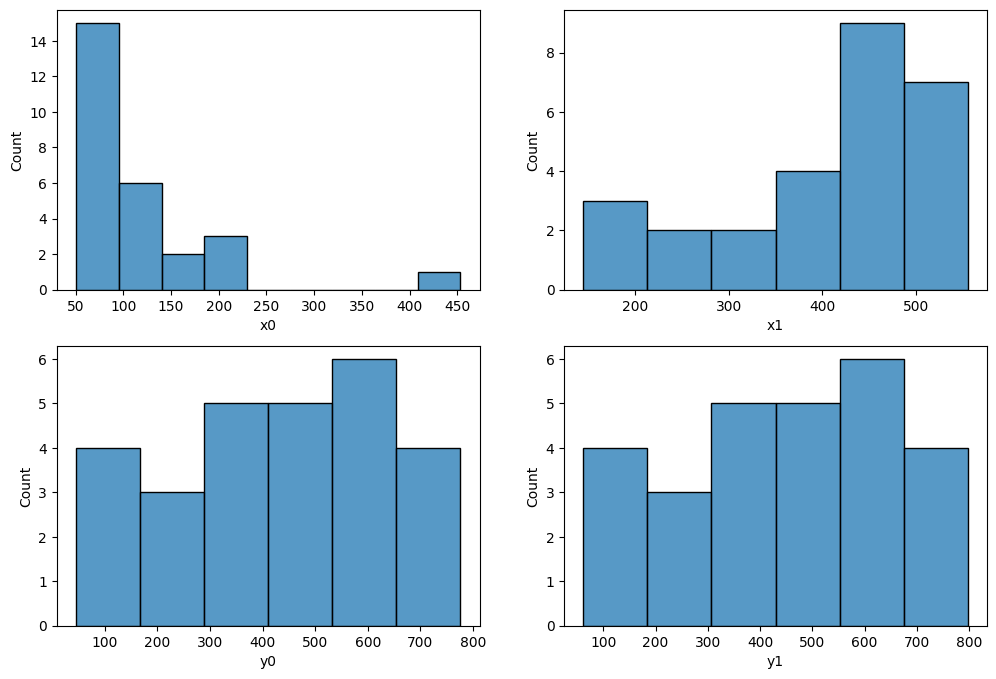

In [12]:
fig, axes = plt.subplots(2,2,figsize=(12,8))

axes = axes.flatten()

for i, col in enumerate(["x0","x1","y0","y1"]):
    sns.histplot(df.loc[df.page==1,col], ax = axes[i])

In [13]:
for idx, row in df.loc[df.section == 1,["text","y0","y1"]].iterrows():
    print(f"{idx:3}, {row.y0:6.2f}, {row.text}")

y0 = df.loc[27,"y0"]

df[df.y0 == y0]

 27,  48.78, SECTION I 
 28,  48.78, COMPREHENDING 
 29,  48.78, (100 marks) 
481,  52.56, SECTION II                          COMPOSING                        (100 marks) 


x0    y0     x1    y1    dL  n_spans       font_list   common_font  \
27  42.54 48.78 129.26 69.88  0.00        1  [Cambria,Bold]  Cambria,Bold   
28 222.55 48.78 376.41 69.88  0.00        1  [Cambria,Bold]  Cambria,Bold   
29 438.57 48.78 546.02 69.88 43.67        1  [Cambria,Bold]  Cambria,Bold   

       mode_font  n_words  ...  font_sizes  mode_font_size font_size dual_col  \
27  Cambria,Bold        2  ...      [18.0]           18.00     18.00        0   
28  Cambria,Bold        1  ...      [18.0]           18.00     18.00        0   
29  Cambria,Bold        2  ...      [18.0]           18.00     18.00        0   

    caption  instruction  footer  section  title  page  
27        0            0       0        1      0     2  
28        0            0       0        1      0     2  
29        0            0       0        1      0     2  

[3 rows x 23 columns]

In [15]:

page_2 = df[df.page==2].copy()
val_counts = page_2.y0.value_counts()
val_counts[val_counts>1]

y0
48.78     3
629.46    2
658.74    2
795.94    2
673.38    2
702.66    2
688.02    2
732.00    2
717.36    2
644.10    2
Name: count, dtype: int64

In [ ]:
page_2.loc[page_2.y0>629,["y0","x0","text"]]

y0     x0                                                text  page
86  629.46 310.20        Another Vandello experiment showed that the      2
87  629.46  47.94         sits rather uncomfortably with humankind’s      2
88  644.10 310.20            appeal of the underdog lives or dies on      2
89  644.10  47.94             known fixation on status and prestige.      2
90  658.74 310.20      perceptions of injustice.  When asked to pick      2
91  658.74  47.94      According to social identity theory, we often      2
92  673.38 310.20      their favourites from a pair of sports teams,      2
93  673.38  47.94     derive our self-esteem from the success of our      2
94  688.02 310.20       the participants tended to prefer those with      2
95  688.02  47.94       group.  Why would we willingly put ourselves      2
96  702.66  47.94           through disappointment by supporting the      2
97  702.66 310.20   the poorest track record, but this effect shrank      2
98  717.36 310.20         if they found that the team was awash with      2
99  717.36  47.94  ‘back runner’ who is far less likely to bring us       2
100 732.00 310.20       cash.  Then, the series of previous failures      2
101 732.00  47.94       success-by association?  It would make much       2
102 746.64  47.94      more sense to align ourselves with the likely      2
103 795.94  42.54               Leaving Certificate Examination 2025      2
104 795.94 294.90                                                  2      2
105 809.08  42.54                   English – Higher Level – Paper 1      2

In [ ]:
pd.DataFrame.groupby()

In [32]:
df.h.value_counts()

h
12.00    455
10.98     14
10.02     13
16.38      8
16.38      8
10.02      6
21.10      6
21.10      4
28.13      3
25.81      3
11.74      3
21.10      3
16.38      2
16.02      2
18.78      2
10.98      2
13.86      2
16.02      1
13.01      1
8.52       1
12.00      1
10.02      1
11.77      1
14.06      1
23.42      1
Name: count, dtype: int64

In [ ]:
tol = 0.04

df["y0_group"] = (df["y0"] / tol).round().astype(int)

df["y0_count"] = df.groupby(by=["page","y0_group"])["y0"].transform("count")
df.drop("y0_group",axis=1,inplace=True)

page_2 = df[df.page==2].copy()


In [29]:
page_2.columns

Index(['x0', 'y0', 'x1', 'y1', 'dL', 'n_spans', 'font_list', 'common_font',
       'mode_font', 'n_words', 'w', 'h', 'text', 'font_sizes',
       'mode_font_size', 'font_size', 'dual_col', 'caption', 'instruction',
       'footer', 'section', 'title', 'page', 'y0_count'],
      dtype='object')

In [31]:
page_2.loc[page_2.y0_count>1,["x0","y0","text","font_size","y0_count"]]

x0     y0                                                text  \
27   42.54  48.78                                          SECTION I    
28  222.55  48.78                                      COMPREHENDING    
29  438.57  48.78                                        (100 marks)    
86  310.20 629.46        Another Vandello experiment showed that the    
87   47.94 629.46         sits rather uncomfortably with humankind’s    
88  310.20 644.10            appeal of the underdog lives or dies on    
89   47.94 644.10             known fixation on status and prestige.    
90  310.20 658.74      perceptions of injustice.  When asked to pick    
91   47.94 658.74      According to social identity theory, we often    
92  310.20 673.38      their favourites from a pair of sports teams,    
93   47.94 673.38     derive our self-esteem from the success of our    
94  310.20 688.02       the participants tended to prefer those with    
95   47.94 688.02       group.  Why would we willingly put ourselves    
96   47.94 702.66           through disappointment by supporting the    
97  310.20 702.66   the poorest track record, but this effect shrank    
98  310.20 717.36         if they found that the team was awash with    
99   47.94 717.36  ‘back runner’ who is far less likely to bring us     
100 310.20 732.00       cash.  Then, the series of previous failures    
101  47.94 732.00       success-by association?  It would make much     
103  42.54 795.94               Leaving Certificate Examination 2025    
104 294.90 795.94                                                  2    

     font_size  y0_count  
27       18.00         3  
28       18.00         3  
29       18.00         3  
86       12.00         2  
87       12.00         2  
88       12.00         2  
89       12.00         2  
90       12.00         2  
91       12.00         2  
92       12.00         2  
93       12.00         2  
94       12.00         2  
95       12.00         2  
96       12.00         2  
97       12.00         2  
98       12.00         2  
99       12.00         2  
100      12.00         2  
101      12.00         2  
103      10.02         2  
104      10.98         2

In [ ]:
def find_join_candidates(df, y_tolerance=0.5):
    """
    Identify line indices in the dataframe that are candidates
    for being joined (i.e., share y0 and y1 within tolerance).
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe returned by get_line_df().
    y_tolerance : float
        Tolerance for considering y0/y1 equal.
        
    Returns
    -------
    list of lists
        Each sublist contains the row indices of lines that
        are candidates for joining into one line.
    """
    groups = []
    used = set()

    for i, row in df.iterrows():
        if i in used:
            continue

        y0, y1 = row["y0"], row["y1"]
        group = [i]

        # Compare with other lines
        for j, other in df.loc[i+1:].iterrows():
            if j in used:
                continue
            if abs(y0 - other["y0"]) <= y_tolerance and abs(y1 - other["y1"]) <= y_tolerance:
                group.append(j)
                used.add(j)

        if len(group) > 1:
            # Sort group left-to-right by x0
            group = sorted(group, key=lambda idx: df.loc[idx, "x0"])
            groups.append(group)

    return groups
find_join_candidates(df,0)

[[27, 28, 29],
 [87, 86],
 [89, 88],
 [91, 90],
 [93, 92],
 [95, 94],
 [96, 97],
 [99, 98],
 [101, 100],
 [103, 177, 257, 329, 403, 478, 104, 178, 258, 330, 404, 479],
 [105, 179, 259, 331, 405, 480],
 [107, 106],
 [108, 109],
 [111, 110],
 [112, 113],
 [183, 115],
 [386, 156, 385],
 [161, 162],
 [163, 164],
 [165, 166],
 [169, 170],
 [196, 195],
 [198, 197],
 [209, 210],
 [212, 211],
 [213, 214],
 [216, 215],
 [236, 235],
 [237, 238],
 [239, 240],
 [242, 241],
 [260, 261],
 [263, 262],
 [264, 265],
 [267, 266],
 [268, 269],
 [271, 270],
 [272, 273],
 [275, 274],
 [276, 277],
 [279, 278],
 [280, 281],
 [283, 282],
 [284, 285],
 [301, 300],
 [302, 303],
 [305, 304],
 [306, 307],
 [313, 314],
 [317, 318],
 [321, 322],
 [340, 339],
 [342, 341],
 [344, 343],
 [361, 362],
 [364, 363],
 [365, 366],
 [368, 367],
 [388, 387],
 [406, 407],
 [409, 408],
 [410, 411],
 [413, 412],
 [414, 415],
 [417, 416],
 [418, 419],
 [420, 421],
 [423, 422],
 [424, 425],
 [427, 426],
 [428, 429],
 [435, 434],
 

In [ ]:
df.loc[ [87,86] ,["y0","y1","text"]]

y0     y1                                          text
87 629.46 641.46   sits rather uncomfortably with humankind’s 
86 629.46 641.46  Another Vandello experiment showed that the

In [ ]:
mask1 = (large_font + bold_font + pages + uncategorised + centred + top) >=5
mask2 = large_font & bold_font & pages & uncategorised & centred & top 
print(mask1.sum(), mask2.sum())

0 6


In [ ]:
large_font.astype(int) + bold_font.astype(int)

0      2
1      2
2      2
3      2
4      2
      ..
449    1
450    2
451    1
452    2
453    1
Length: 454, dtype: int64

In [ ]:
mask = is_buffered_line(row,6)
buffed_lines = row.loc[mask,["x0","x1","y0","y1","text","page","font_size","common_font", "font_list"]].copy()
buffed_lines.head(40)

x0     x1     y0     y1  \
23  476.34 595.29 808.69 819.78   
144  56.70 232.02 464.87 478.15   
145  56.70 597.36 478.67 491.95   
147  56.70 595.87 520.07 533.35   
149  56.70 597.96 561.47 574.75   
155 476.34 595.29 808.69 819.78   
157  56.70 354.99  47.36  62.84   
258  56.70 181.65 166.67 179.95   
276  85.08 568.32 438.41 451.69   
279  56.70 595.26 479.81 493.09   
280  56.70 595.93 507.41 520.69   
284  56.70 597.60 631.61 644.89   
285 476.34 595.29 808.69 819.78   
401  85.07 597.59 577.55 590.83   
402  56.70 595.72 591.35 604.63   
405  56.70 595.63 632.75 646.03   
407  56.70 596.98 674.15 687.43   
412 476.34 595.29 808.69 819.78   
425  69.18 534.09 332.39 345.67   
431  69.18 527.59 484.19 497.47   
432  69.18 148.19 497.99 511.27   
439  69.18 494.82 663.59 676.87   
443  69.18 518.49 732.59 745.87   
444  69.18 121.92 746.33 759.61   
447 476.34 595.29 808.69 819.78   
451 471.36 595.33 808.69 819.78   

                                                  text  page  font_size  \
23             Page 1 of 12                                1      10.02   
144                    emerges from this interview.        3      12.00   
145          Do you agree?  Support your view with ...     3      12.00   
147            to illustrate this text.  Briefly ex...     3      12.00   
149            Refer to the text (content and style...     3      12.00   
155            Page 3 of 12                                3      10.02   
157                                                ...     4      13.98   
258                       the path as you walk”.           5      12.00   
276  In your own words outline the argument he make...     5      12.00   
279           Select the quotation that made the gr...     5      12.00   
280  (iii) Identify and comment on four elements of...     5      12.00   
284  express your hopes for planet Earth in the yea...     5      12.00   
285            Page 5 of 12                                5      10.02   
401  From your reading of the text what qualities d...     7      12.00   
402                                                ...     7      12.00   
405           In your response, compare and contras...     7      12.00   
407            Discuss this view with reference to ...     7      12.00   
412            Page 7 of 12                                7      10.02   
425         Write an article (serious and/or light-...     8      12.00   
431         Write a personal essay about your under...     8      12.00   
432                                        important.      8      12.00   
439         Write a practical Guide for Young Peopl...     8      12.00   
443          Write a short story in which two unusu...     8      12.00   
444                                             time.      8      12.00   
447            Page 9 of 12                                9      10.02   
451           Page 11 of 12                               11      10.02   

                common_font                                          font_list  
23   TimesNewRomanPS-BoldMT                           [TimesNewRomanPS-BoldMT]  
144       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
145       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
147       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
149       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
155  TimesNewRomanPS-BoldMT                           [TimesNewRomanPS-BoldMT]  
157  TimesNewRomanPS-BoldMT                           [TimesNewRomanPS-BoldMT]  
258       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
276       TimesNewRomanPSMT                                [TimesNewRomanPSMT]  
279         TimesNewRomanPS  [TimesNewRomanPSMT, TimesNewRomanPS-BoldMT, Ti...  
280         TimesNewRomanPS  [TimesNewRomanPSMT, TimesNewRomanPS-BoldMT, Ti...  
284       TimesNewRomanPSMT                                [Time

In [ ]:
draw_rectangles_for_all_pages('/home/daniel/ogham-cloud/Exams/english/AL/LC002ALP100EV_2010.pdf',"fart", buffed_lines)

mask         = is_buffered_line(row,6)
buffed_lines = row.loc[mask,["x0","x1","y0","y1","text","page","font_size","common_font", "font_list"]].copy()
fixed_lines  = buffed_lines.copy()

fixed_lines.loc[:,["x0","x1","text"]] = fixed_lines.apply(re_box_line,axis=1)
fixed_lines.loc[23].x1, buffed_lines.loc[23].x1

draw_rectangles_for_all_pages('/home/daniel/ogham-cloud/Exams/english/AL/LC002ALP100EV_2010.pdf',"anus", fixed_lines)
